In [1]:
import sys

# 推奨された方法ではない。
# 参照:https://note.com/iamhacchin/n/n8eb3efafadf9
sys.path.append("../scripts/")
from ideal_robot import *
from scipy.stats import expon, norm, uniform


In [2]:
class Robot(IdealRobot):
    def __init__(
        self,
        pose,
        agent=None,
        sensor=None,
        color="black",
        noise_per_meter=5,
        noise_std=math.pi / 60,
        bias_rate_stds=(0.1, 0.1),
        expected_stuck_time=1e100,
        expected_escape_time=1e-100,
        expected_kidnap_time=1e100,
        kidnap_range_x=(-5.0, 5.0),
        kidnap_range_y=(-5.0, 5.0),
    ):
        """コンストラクタ

        Args:
            pose (_type_): _description_
            agent (_type_, optional): _description_. Defaults to None.
            sensor (_type_, optional): _description_. Defaults to None.
            color (str, optional): _description_. Defaults to "black".
            noise_per_meter (int, optional): 1mあたりの小石の数. Defaults to 5.
            noise_std (_type_, optional): 小石を踏んだときにロボットの向きθに発生するノイズの標準偏差[deg]. Defaults to math.pi/60.
            bias_rate_stds (_type_, optional): 移動速度に付与するバイアス係数を生成するためのガウス分布の標準偏差. Defaults to (0.1,0.1)
            expected_stuck_time (_type_, optional): スタックまでの時間の期待値[s]. Defaults to 1e100
            expected_escape_time (_type_, optional): スタックから脱出するまでの時間の期待値[s]. Defaults to 1e-100
            expected_kidnap_time (_type_, optional): 誘拐が起こるまでの時間の期待値[s]. Defaults to 1e-100
            kidnap_range_x (_type_, optional): 誘拐後に置かれるロボットの位置を選ぶ範囲のx座標[m]. Defaults to (-5.0,5.0)
            kidnap_range_y (_type_, optional): 誘拐後に置かれるロボットの位置を選ぶ範囲のy座標[m]. Defaults to (-5.0,5.0)
        """
        super().__init__(pose, agent, sensor, color)
        # 指数分布のオブジェクト生成
        # scaleはλの逆数に相当する。1e-100はゼロ割を防止するためのテクニック
        self.noise_pdf = expon(scale=1.0 / (1e-100 + noise_per_meter))
        # 最初に小石を踏むまでの道のりを指数分布からrvs()を使ってドローしている
        self.distance_until_noise = self.noise_pdf.rvs()
        # θに加えるノイズを決めるためのガウス分布のオブジェクトを生成
        self.theta_noise = norm(scale=noise_std)
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rate_stds[0])
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rate_stds[1])
        self.stuck_pdf = expon(scale=expected_stuck_time)
        self.escape_pdf = expon(scale=expected_escape_time)
        self.time_until_stuck = self.stuck_pdf.rvs()
        self.time_until_escape = self.escape_pdf.rvs()
        self.is_stuck = False
        self.kidnap_pdf = expon(scale=expected_kidnap_time)
        self.time_until_kidnap = self.kidnap_pdf.rvs()
        rx, ry = kidnap_range_x, kidnap_range_y
        self.kidnap_dist = uniform(
            loc=(rx[0], ry[0], 0.0), scale=(rx[1] - rx[0], ry[1] - ry[0], 2 * math.pi)
        )

    def noise(self, pose, nu, omega, time_interval):

        # このメソッドが呼ばれるたびにdistance_until_noiseを経過時間分だけ減らす。
        # abs(nu) * time_interval = 速度nu[m/s]をtime_interval間続けたとき、つまり直進方向の移動距離[m]
        # self.r * abs(omega) * time_interval = 半径r[m]のロボットが角速度omega[rad/s]をtime_interval間続けたとき、つまり回転方向の移動距離[m]
        # @note 回転方向の速度vはr*omegaで得られる。速度vに時間をかけて移動距離を算出
        self.distance_until_noise -= (
            abs(nu) * time_interval + self.r * abs(omega) * time_interval
        )

        # 0以下なら小石を踏んだを判定
        if self.distance_until_noise <= 0.0:
            # 新しい小石を踏むまでの道のりを生成
            self.distance_until_noise += self.noise_pdf.rvs()
            # ロボットの向きにノイズを付与
            pose[2] += self.theta_noise.rvs()

        return pose

    def bias(self, nu, omega):
        return nu * self.bias_rate_nu, omega * self.bias_rate_omega

    def stuck(self, nu, omega, time_interval):
        if self.is_stuck:
            self.time_until_escape -= time_interval
            if self.time_until_escape <= 0.0:
                self.time_until_escape += self.escape_pdf.rvs()
                self.is_stuck = False
        else:
            self.time_until_stuck -= time_interval
            if self.time_until_stuck <= 0.0:
                self.time_until_stuck += self.stuck_pdf.rvs()
                self.is_stuck = True

        return nu * (not self.is_stuck), omega * (not self.is_stuck)

    def kidnap(self, pose, time_interval):
        self.time_until_kidnap -= time_interval
        if self.time_until_kidnap <= 0.0:
            self.time_until_kidnap += self.kidnap_pdf.rvs()
            return np.array(self.kidnap_dist.rvs()).T
        else:
            return pose

    def one_step(self, time_interval):
        if not self.agent:
            return
        if self.sensor:
            obs = self.sensor.data(self.pose)
        else:
            obs = None
        nu, omega = self.agent.decision(obs)
        nu, omega = self.bias(nu, omega)
        nu, omega = self.stuck(nu, omega, time_interval)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)
        self.pose = self.kidnap(self.pose, time_interval)


In [3]:
# センサー値に対する雑音を実装
# @note ガウス分布状にセンサー値をばらつかせる


class Camera(IdealCamera):
    def __init__(
        self,
        env_map,
        distance_range=(0.5, 6.0),
        direction_range=(-math.pi / 3, math.pi / 3),
        distance_noise_rate=0.1,
        direction_noise=math.pi / 90,
    ):
        super().__init__(env_map, distance_range, direction_range)
        self.distance_noise_rate = distance_noise_rate
        self.direction_noise = direction_noise


    def noise(self, relpos):
        ell=norm.rvs(loc=relpos[0], scale=relpos[0]*self.distance_noise_rate)
        phi=norm.rvs(loc=relpos[1], scale=self.direction_noise)
        return np.array([ell,phi]).T

    def data(self, cam_pose):
        observed=[]
        for lm in self.map.landmarks:
            z=self.observation.funciton(cam_pose, lm.pos)
            if self.visible(z):
                z=self.noise(z)
                observed.append((z,lm.id))
        
        self.lastdata=observed
        return observed

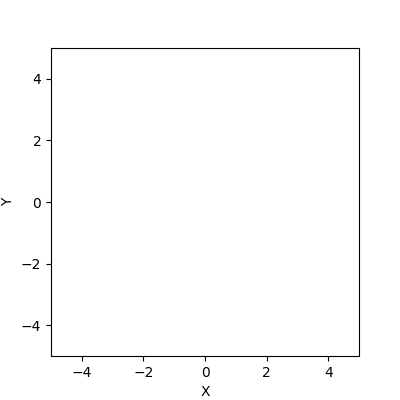

In [4]:
world = World(30, 0.1)

m=Map()
m.append_landmark(Landmark(-4,2))
m.append_landmark(Landmark(2,-3))
m.append_landmark(Landmark(3,3))
world.append(m)

circling=Agent(0.2, 10.0/180*math.pi)
r=Robot(np.array([0,0,0]).T, sensor=Camera(m), agent=circling)
world.append(r)

%matplotlib widget
world.draw()


指数分布の確率密度関数の式(4.1)
$$
p(x|\lambda) = {\lambda}{e}^{-{\lambda}{x}}
$$

Robotクラスでは上記の式を用いて、環境にランダムに小石が落ちておりそれを踏んだ直後にロボットの向きθをランダムにずらすプログラムを実装している。

$\lambda$は道のりあたりに踏みつける小石の数の期待値に相当する。逆数の$1/\lambda$は小石１つ踏みつけるまでの道のりの期待値に相当する。